#  Imported Required Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

#CORE LIBRARIES 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import json
from collections import Counter
import hashlib

#IMAGE PROCESSING
from skimage import color, exposure, filters, feature
from skimage.metrics import structural_similarity as ssim

#DATA VISUALIZATION
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.gridspec as gridspec

#UTILITIES
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#MACHINE LEARNING
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Suppress specific warnings that might appear later
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

print("All libraries imported successfully!")
print("CUDA warnings suppressed - safe to proceed")

E0000 00:00:1760465211.282823      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760465211.353383      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


All libraries imported successfully!
CUDA warnings suppressed - safe to proceed


# Dataset Path Setup & Exploration

In [2]:
# DATASET PATH CONFIGURATION
BASE_PATH = "/kaggle/input/dataset-for-classifying-rice-varieties-in-bd"

def explore_dataset_structure():
    """Explore and understand the dataset structure"""
    print(" Exploring Dataset Structure...")
    print("=" * 50)
    
    if not os.path.exists(BASE_PATH):
        print(f"Base path not found: {BASE_PATH}")
        return None
    
    # List main directory
    main_items = os.listdir(BASE_PATH)
    print(f"Main directory contains: {main_items}")
    
    # Explore each item
    for item in main_items:
        item_path = os.path.join(BASE_PATH, item)
        if os.path.isdir(item_path):
            print(f"\n Exploring: {item}/")
            subitems = os.listdir(item_path)
            
            for subitem in subitems:
                subitem_path = os.path.join(item_path, subitem)
                if os.path.isdir(subitem_path):
                    # Check if this is a class directory (contains images)
                    files = [f for f in os.listdir(subitem_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                    if files:
                        print(f"   {subitem}/: {len(files)} images")
                        print(f"     Sample files: {files[:3]}")  # Show first 3 files
                    else:
                        # Check one level deeper
                        deeper_items = os.listdir(subitem_path)
                        print(f"   {subitem}/ contains: {deeper_items[:5]}")  # Show first 5 items

# Run exploration
explore_dataset_structure()

 Exploring Dataset Structure...
Main directory contains: ['Rice Varieties in Bangladesh']

 Exploring: Rice Varieties in Bangladesh/
   Augmented/ contains: ['BRRI67', 'Binadhan10', 'BD56', 'Binadhan17', 'BD33']
   Original/ contains: ['BRRI67', 'Binadhan10', 'BD56', 'Binadhan17', 'BD33']


# Dataset Loading Function

In [3]:
#DATASET LOADING FUNCTIONS
def find_correct_paths():
    """Automatically find the correct paths for original and augmented data"""
    possible_paths = {
        'original': [
            os.path.join(BASE_PATH, "Rice Varieties in Bangladesh", "Original"),
            os.path.join(BASE_PATH, "Original"),
            os.path.join(BASE_PATH, "original"),
            os.path.join(BASE_PATH, "Rice Varieties in Bangladesh", "original")
        ],
        'augmented': [
            os.path.join(BASE_PATH, "Rice Varieties in Bangladesh", "Augmented"),
            os.path.join(BASE_PATH, "Augmented"),
            os.path.join(BASE_PATH, "augmented"),
            os.path.join(BASE_PATH, "Rice Varieties in Bangladesh", "augmented")
        ]
    }
    
    found_paths = {}
    
    for data_type, paths in possible_paths.items():
        for path in paths:
            if os.path.exists(path):
                found_paths[data_type] = path
                print(f" Found {data_type} data at: {path}")
                break
        else:
            print(f" Could not find {data_type} data")
            
    return found_paths

def load_rice_dataset(data_type="original"):
    """Load rice dataset with comprehensive information"""
    paths = find_correct_paths()
    
    if data_type not in paths:
        print(f" {data_type} data not found!")
        return None
    
    base_path = paths[data_type]
    print(f"\n Loading {data_type} dataset from: {base_path}")
    
    # Get all class directories
    classes = [d for d in os.listdir(base_path) 
               if os.path.isdir(os.path.join(base_path, d))]
    
    print(f" Found {len(classes)} rice varieties")
    
    image_paths = []
    labels = []
    file_sizes = []
    
    # Load image information
    for class_name in tqdm(classes, desc=f"Loading {data_type} classes"):
        class_path = os.path.join(base_path, class_name)
        
        for img_file in os.listdir(class_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, img_file)
                image_paths.append(img_path)
                labels.append(class_name)
                
                # Get file size
                file_sizes.append(os.path.getsize(img_path))
    
    # Create DataFrame
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels,
        'file_size': file_sizes
    })
    
    print(f" Loaded {len(df)} images from {df['label'].nunique()} classes")
    print(f" Class distribution:")
    print(df['label'].value_counts().head())
    
    return df

# Load datasets
print("Loading datasets...")
df_original = load_rice_dataset("original")
df_augmented = load_rice_dataset("augmented") if 'augmented' in find_correct_paths() else None

Loading datasets...
 Found original data at: /kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Original
 Found augmented data at: /kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Augmented

 Loading original dataset from: /kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Original
 Found 38 rice varieties


Loading original classes: 100%|██████████| 38/38 [00:25<00:00,  1.49it/s]


 Loaded 19000 images from 38 classes
 Class distribution:
label
BRRI67        500
Binadhan10    500
BD56          500
Binadhan17    500
BD33          500
Name: count, dtype: int64
 Found original data at: /kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Original
 Found augmented data at: /kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Augmented
 Found original data at: /kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Original
 Found augmented data at: /kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Augmented

 Loading augmented dataset from: /kaggle/input/dataset-for-classifying-rice-varieties-in-bd/Rice Varieties in Bangladesh/Augmented
 Found 38 rice varieties


Loading augmented classes: 100%|██████████| 38/38 [02:03<00:00,  3.24s/it]

 Loaded 76000 images from 38 classes
 Class distribution:
label
BRRI67        2000
Binadhan10    2000
BD56          2000
Binadhan17    2000
BD33          2000
Name: count, dtype: int64


# Comprehensive EDA Analysis Functions

In [4]:
#COMPREHENSIVE EDA ANALYSIS FUNCTIONS

def analyze_color_distributions(df, sample_size=1000):
    """(i) RGB and HSV histogram analysis with per-class statistics"""
    print(" Analyzing Color Distributions...")
    
    sampled_df = df.sample(min(sample_size, len(df)), random_state=42)
    
    # Initialize storage
    analysis_results = {
        'rgb_means': [], 'rgb_stds': [], 
        'hsv_means': [], 'hsv_stds': [],
        'brightness': [], 'contrast': [], 
        'saturation_clipping': [],
        'per_class_stats': {}
    }
    
    for img_path in tqdm(sampled_df['image_path'], desc="Processing images"):
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            
            # RGB Analysis
            rgb_mean = np.mean(img_rgb, axis=(0,1))
            rgb_std = np.std(img_rgb, axis=(0,1))
            analysis_results['rgb_means'].append(rgb_mean)
            analysis_results['rgb_stds'].append(rgb_std)
            
            # HSV Analysis
            hsv_mean = np.mean(img_hsv, axis=(0,1))
            hsv_std = np.std(img_hsv, axis=(0,1))
            analysis_results['hsv_means'].append(hsv_mean)
            analysis_results['hsv_stds'].append(hsv_std)
            
            # Brightness and Contrast
            brightness = np.mean(img_hsv[:,:,2])  # Value channel
            contrast = np.std(img_rgb)
            analysis_results['brightness'].append(brightness)
            analysis_results['contrast'].append(contrast)
            
            # Saturation Clipping
            saturated_pixels = np.sum(img_hsv[:,:,1] > 250)  # Saturation channel
            total_pixels = img_hsv.shape[0] * img_hsv.shape[1]
            analysis_results['saturation_clipping'].append(saturated_pixels / total_pixels)
            
        except Exception as e:
            continue
    
    # Convert to numpy arrays
    for key in ['rgb_means', 'rgb_stds', 'hsv_means', 'hsv_stds', 
                'brightness', 'contrast', 'saturation_clipping']:
        analysis_results[key] = np.array(analysis_results[key])
    
    return analysis_results

def analyze_image_characteristics(df):
    """(ii) Resolution and aspect ratio analysis"""
    print(" Analyzing Image Characteristics...")
    
    resolutions = []
    aspect_ratios = []
    
    for img_path in tqdm(df['image_path'], desc="Checking dimensions"):
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                resolutions.append((width, height))
                aspect_ratios.append(width / height)
        except:
            continue
    
    return resolutions, aspect_ratios

def analyze_image_quality(df, sample_size=500):
    """(iii) Sharpness and noise analysis"""
    print(" Analyzing Image Quality (Sharpness & Noise)...")
    
    sharpness_vals = []
    noise_estimates = []
    
    sampled_df = df.sample(min(sample_size, len(df)), random_state=42)
    
    for img_path in tqdm(sampled_df['image_path'], desc="Quality analysis"):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            
            # Sharpness - Laplacian variance
            laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
            sharpness_vals.append(laplacian_var)
            
            # Noise estimate - using variance of smoothed difference
            blurred = cv2.GaussianBlur(img, (5, 5), 0)
            noise = np.var(img - blurred)
            noise_estimates.append(noise)
            
        except:
            continue
    
    return sharpness_vals, noise_estimates

def analyze_white_balance(df, sample_size=300):
    """(iv) White balance sanity check"""
    print(" Analyzing White Balance...")
    
    wb_deviations = []
    
    sampled_df = df.sample(min(sample_size, len(df)), random_state=42)
    
    for img_path in tqdm(sampled_df['image_path'], desc="White balance check"):
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Gray-world assumption check
            channel_means = np.mean(img_rgb, axis=(0,1))
            avg_mean = np.mean(channel_means)
            deviation = np.std(channel_means / avg_mean)
            wb_deviations.append(deviation)
            
        except:
            continue
    
    return wb_deviations

def detect_duplicate_images(df, threshold=0.95):
    """(v) Duplicate detection using perceptual hashing and SSIM"""
    print(" Detecting Duplicate Images...")
    
    hashes = {}
    duplicates = []
    
    for idx, img_path in enumerate(tqdm(df['image_path'], desc="Duplicate detection")):
        try:
            with Image.open(img_path) as img:
                # Convert to grayscale for hashing
                img_gray = img.convert('L')
                
                # Simple hash (perceptual hash would be better)
                img_hash = hashlib.md5(img_gray.tobytes()).hexdigest()
                
                if img_hash in hashes:
                    duplicates.append({
                        'image1': hashes[img_hash],
                        'image2': img_path,
                        'hash_match': True
                    })
                else:
                    hashes[img_hash] = img_path
        except:
            continue
    
    print(f" Found {len(duplicates)} potential duplicates based on hashing")
    return duplicates

def analyze_class_distribution(df):
    """(vi) Class balance analysis"""
    print(" Analyzing Class Distribution...")
    
    class_counts = df['label'].value_counts()
    
    # Calculate statistics
    stats = {
        'total_images': len(df),
        'total_classes': len(class_counts),
        'min_images_per_class': class_counts.min(),
        'max_images_per_class': class_counts.max(),
        'mean_images_per_class': class_counts.mean(),
        'std_images_per_class': class_counts.std()
    }
    
    return class_counts, stats

def test_data_augmentations(df, sample_class=None):
    """(vii) Augmentation probe"""
    print(" Testing Data Augmentations...")
    
    if sample_class:
        sample_img_path = df[df['label'] == sample_class].iloc[0]['image_path']
    else:
        sample_img_path = df.iloc[0]['image_path']
    
    try:
        original_img = cv2.imread(sample_img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        augmentations = {
            'Original': original_img,
            'Horizontal Flip': cv2.flip(original_img, 1),
            'Vertical Flip': cv2.flip(original_img, 0),
            '90° Rotation': cv2.rotate(original_img, cv2.ROTATE_90_CLOCKWISE),
            'Brightness +30%': exposure.adjust_gamma(original_img, gamma=0.7),
            'Brightness -30%': exposure.adjust_gamma(original_img, gamma=1.3),
            'Contrast +50%': exposure.adjust_gamma(original_img, gamma=0.5),
            'Gaussian Blur': cv2.GaussianBlur(original_img, (15, 15), 0),
            'Color Jitter': exposure.adjust_gamma(original_img, gamma=0.8, gain=1.2)
        }
        
        return augmentations
    except:
        return {}

# Run Complete EDA Analysis

In [5]:
#RUN COMPREHENSIVE EDA
def run_complete_eda_analysis(df):
    """Run all EDA analyses and return results"""
    print(" STARTING COMPREHENSIVE EDA ANALYSIS")
    print("=" * 60)
    
    results = {}
    
    # 1. Color Distributions
    results['color_analysis'] = analyze_color_distributions(df)
    
    # 2. Image Characteristics
    results['resolutions'], results['aspect_ratios'] = analyze_image_characteristics(df)
    
    # 3. Image Quality
    results['sharpness'], results['noise'] = analyze_image_quality(df)
    
    # 4. White Balance
    results['white_balance'] = analyze_white_balance(df)
    
    # 5. Duplicate Detection
    results['duplicates'] = detect_duplicate_images(df)
    
    # 6. Class Distribution
    results['class_counts'], results['class_stats'] = analyze_class_distribution(df)
    
    # 7. Augmentation Probe
    results['augmentations'] = test_data_augmentations(df, sample_class=df['label'].iloc[0] if len(df) > 0 else None)
    
    print("\n COMPREHENSIVE EDA COMPLETED!")
    return results

# Run EDA on original dataset
if df_original is not None:
    eda_results = run_complete_eda_analysis(df_original)
else:
    print(" Cannot run EDA - no dataset loaded")
    eda_results = {}

 STARTING COMPREHENSIVE EDA ANALYSIS
 Analyzing Color Distributions...


Processing images: 100%|██████████| 1000/1000 [01:58<00:00,  8.45it/s]


 Analyzing Image Characteristics...


Checking dimensions: 100%|██████████| 19000/19000 [01:39<00:00, 190.98it/s]


 Analyzing Image Quality (Sharpness & Noise)...


Quality analysis: 100%|██████████| 500/500 [00:04<00:00, 117.49it/s]


 Analyzing White Balance...


White balance check: 100%|██████████| 300/300 [00:05<00:00, 55.95it/s]


 Detecting Duplicate Images...


Duplicate detection: 100%|██████████| 19000/19000 [01:30<00:00, 209.71it/s]

 Found 0 potential duplicates based on hashing
 Analyzing Class Distribution...
 Testing Data Augmentations...

 COMPREHENSIVE EDA COMPLETED!


# Visualization Functions

In [6]:
#COMPREHENSIVE VISUALIZATIONS

def plot_color_analysis(results):
    """Plot RGB/HSV distributions and statistics"""
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(3, 3, figure=fig)
    
    # RGB Mean Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    rgb_means = results['color_analysis']['rgb_means']
    ax1.boxplot([rgb_means[:,0], rgb_means[:,1], rgb_means[:,2]], labels=['R', 'G', 'B'])
    ax1.set_title('RGB Channel Means Distribution')
    ax1.set_ylabel('Mean Pixel Value')
    
    # HSV Mean Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    hsv_means = results['color_analysis']['hsv_means']
    ax2.boxplot([hsv_means[:,0], hsv_means[:,1], hsv_means[:,2]], labels=['H', 'S', 'V'])
    ax2.set_title('HSV Channel Means Distribution')
    ax2.set_ylabel('Mean Pixel Value')
    
    # Brightness and Contrast
    ax3 = fig.add_subplot(gs[0, 2])
    brightness = results['color_analysis']['brightness']
    contrast = results['color_analysis']['contrast']
    ax3.scatter(brightness, contrast, alpha=0.6)
    ax3.set_xlabel('Brightness')
    ax3.set_ylabel('Contrast')
    ax3.set_title('Brightness vs Contrast')
    
    # Saturation Clipping
    ax4 = fig.add_subplot(gs[1, 0])
    saturation_clipping = results['color_analysis']['saturation_clipping']
    ax4.hist(saturation_clipping, bins=50, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Saturation Clipping Ratio')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Saturation Clipping Distribution')
    
    # RGB Correlation
    ax5 = fig.add_subplot(gs[1, 1])
    rgb_corr = np.corrcoef(rgb_means.T)
    im = ax5.imshow(rgb_corr, cmap='coolwarm', vmin=-1, vmax=1)
    ax5.set_xticks([0, 1, 2])
    ax5.set_yticks([0, 1, 2])
    ax5.set_xticklabels(['R', 'G', 'B'])
    ax5.set_yticklabels(['R', 'G', 'B'])
    ax5.set_title('RGB Channels Correlation')
    plt.colorbar(im, ax=ax5)
    
    # File Size Distribution
    ax6 = fig.add_subplot(gs[1, 2])
    if 'file_size' in df_original.columns:
        file_sizes_mb = df_original['file_size'] / (1024 * 1024)
        ax6.hist(file_sizes_mb, bins=50, alpha=0.7, edgecolor='black')
        ax6.set_xlabel('File Size (MB)')
        ax6.set_ylabel('Frequency')
        ax6.set_title('Image File Size Distribution')
    
    plt.tight_layout()
    plt.show()

def plot_image_characteristics(results):
    """Plot resolution and aspect ratio distributions"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Resolution scatter plot
    resolutions = np.array(results['resolutions'])
    if len(resolutions) > 0:
        axes[0,0].scatter(resolutions[:,0], resolutions[:,1], alpha=0.6)
        axes[0,0].set_xlabel('Width (pixels)')
        axes[0,0].set_ylabel('Height (pixels)')
        axes[0,0].set_title('Image Resolutions')
        
        # Add aspect ratio line
        max_dim = max(resolutions.max(), 1000)
        axes[0,0].plot([0, max_dim], [0, max_dim], 'r--', alpha=0.5, label='1:1 Aspect Ratio')
        axes[0,0].legend()
    
    # Aspect ratio distribution
    aspect_ratios = results['aspect_ratios']
    axes[0,1].hist(aspect_ratios, bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Aspect Ratio (Width/Height)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Aspect Ratio Distribution')
    axes[0,1].axvline(1.0, color='red', linestyle='--', label='1:1 Square')
    axes[0,1].legend()
    
    # Sharpness distribution
    sharpness = results['sharpness']
    axes[1,0].hist(sharpness, bins=50, alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Sharpness (Laplacian Variance)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Image Sharpness Distribution')
    
    # White balance deviations
    white_balance = results['white_balance']
    axes[1,1].hist(white_balance, bins=50, alpha=0.7, edgecolor='black')
    axes[1,1].set_xlabel('White Balance Deviation')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('White Balance Consistency')
    
    plt.tight_layout()
    plt.show()

def plot_file_size_distribution(df):
    """Plot file size distribution per class - this will be wavy!"""
    # Calculate average file size per class
    file_size_stats = df.groupby('label')['file_size'].agg(['mean', 'std']).reset_index()
    file_size_stats = file_size_stats.sort_values('mean', ascending=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Average file size per class
    bars1 = ax1.bar(range(len(file_size_stats)), file_size_stats['mean'], 
                   color=plt.cm.viridis(np.linspace(0, 1, len(file_size_stats))))
    ax1.set_xlabel('Rice Varieties')
    ax1.set_ylabel('Average File Size (bytes)')
    ax1.set_title('Average File Size Distribution by Rice Variety\n(Will be Wavy!)', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(file_size_stats)))
    ax1.set_xticklabels(file_size_stats['label'], rotation=90, fontsize=8)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height/1024:.0f}KB', ha='center', va='bottom', fontsize=7, rotation=45)
    
    # Plot 2: File size variability per class
    ax2.errorbar(range(len(file_size_stats)), file_size_stats['mean'], 
                yerr=file_size_stats['std'], fmt='o', color='red', 
                alpha=0.7, capsize=5, capthick=2)
    ax2.set_xlabel('Rice Varieties')
    ax2.set_ylabel('File Size (bytes)')
    ax2.set_title('File Size Variability by Rice Variety', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(file_size_stats)))
    ax2.set_xticklabels(file_size_stats['label'], rotation=90, fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return file_size_stats

def plot_creative_class_distribution(df):
    """Creative visualization for balanced dataset"""
    
    class_counts = df['label'].value_counts()
    
    # Create a spiral or circular visualization
    fig = plt.figure(figsize=(16, 12))
    
    # Subplot 1: Radial bar chart
    ax1 = fig.add_subplot(221, projection='polar')
    angles = np.linspace(0, 2*np.pi, len(class_counts), endpoint=False)
    widths = 2 * np.pi / len(class_counts)
    bars = ax1.bar(angles, class_counts.values, width=widths, 
                  color=plt.cm.plasma(np.linspace(0, 1, len(class_counts))),
                  alpha=0.7, edgecolor='black')
    ax1.set_title('Radial Distribution of Rice Varieties\n(All Equal = Perfect Circle!)', 
                  fontsize=12, fontweight='bold', pad=20)
    ax1.set_xticks(angles)
    ax1.set_xticklabels(class_counts.index, fontsize=6)
    
    # Subplot 2: Treemap style
    ax2 = fig.add_subplot(222)
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
    wedges, texts = ax2.pie(class_counts.values, labels=class_counts.index, 
                           colors=colors, startangle=90, counterclock=False)
    ax2.set_title('Perfectly Balanced Dataset\n(All varieties have equal samples)', 
                  fontsize=12, fontweight='bold')
    
    # Make labels smaller
    for text in texts:
        text.set_fontsize(6)
    
    # Subplot 3: Network graph style
    ax3 = fig.add_subplot(223)
    nodes = len(class_counts)
    angles = np.linspace(0, 2*np.pi, nodes, endpoint=False)
    radius = 5
    
    # Create circular layout
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    
    # Plot nodes
    scatter = ax3.scatter(x, y, s=300, c=class_counts.values, 
                         cmap='viridis', alpha=0.7, edgecolors='black')
    
    # Add labels
    for i, (xi, yi, label) in enumerate(zip(x, y, class_counts.index)):
        angle = angles[i]
        ha = 'left' if -np.pi/2 <= angle <= np.pi/2 else 'right'
        ax3.annotate(label, (xi, yi), xytext=(5*np.sign(xi), 0), 
                    textcoords='offset points', ha=ha, fontsize=6,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
    
    ax3.set_aspect('equal')
    ax3.set_title('Network Visualization of 38 Rice Varieties', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    # Subplot 4: Statistics highlight
    ax4 = fig.add_subplot(224)
    ax4.axis('off')
    
    stats_text = f"""
     DATASET BALANCE ANALYSIS
    
    Total Varieties: {len(class_counts)}
    Total Images: {class_counts.sum():,}
    
     PERFECT BALANCE ACHIEVED:
    • Each variety: {class_counts.iloc[0]:,} images
    • No class imbalance issues
    • Ideal for machine learning
    
     QUALITY METRICS:
    • Balance Ratio: 1.0 (Perfect)
    • Std Deviation: {class_counts.std():.1f}
    • Min-Max Ratio: 1.0
    
     RECOMMENDATION:
    No sampling strategies needed!
    Proceed with standard training.
    """
    
    ax4.text(0.1, 0.9, stats_text, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle="round", facecolor='lightgreen', alpha=0.7),
             fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

def plot_class_distribution(results):
    """Enhanced class distribution visualization that shows wavy patterns"""
    class_counts = results['class_counts']
    stats = results['class_stats']
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Plot 1: Show FILE SIZE distribution instead of image count (this will be wavy!)
    if 'file_size' in df_original.columns:
        file_size_by_class = df_original.groupby('label')['file_size'].mean().sort_values(ascending=False)
        bars1 = ax1.bar(range(len(file_size_by_class)), file_size_by_class.values, 
                       color=plt.cm.coolwarm(np.linspace(0, 1, len(file_size_by_class))))
        ax1.set_xticks(range(len(file_size_by_class)))
        ax1.set_xticklabels(file_size_by_class.index, rotation=90, fontsize=6)
        ax1.set_ylabel('Average File Size (bytes)')
        ax1.set_title('File Size Distribution by Rice Variety\n(Wavy Pattern Shows Natural Variation)', 
                      fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars1):
            if i % 5 == 0:  # Label every 5th bar to avoid clutter
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height/1024:.0f}KB', ha='center', va='bottom', fontsize=6)
    
    # Plot 2: Creative visualization - show as a perfect circle (acknowledging the balance)
    angles = np.linspace(0, 2*np.pi, len(class_counts), endpoint=False)
    radii = np.full_like(angles, class_counts.values[0])
    
    ax2 = plt.subplot(222, projection='polar')
    bars2 = ax2.bar(angles, radii, width=0.1, alpha=0.7, 
                   color=plt.cm.plasma(np.linspace(0, 1, len(class_counts))))
    ax2.set_title('Radial View: Perfect Balance\n(Forms a perfect circle)', 
                  fontsize=12, fontweight='bold', pad=20)
    ax2.set_xticks(angles)
    ax2.set_xticklabels([f'{label}' for label in class_counts.index], fontsize=5)
    
    # Plot 3: Show brightness variation per class (another wavy pattern)
    ax3 = fig.add_subplot(223)
    if 'color_analysis' in results:
        # Get average brightness per class from a sample
        brightness_by_class = []
        classes = []
        for class_name in class_counts.index[:20]:  # Show first 20 classes
            class_samples = df_original[df_original['label'] == class_name].sample(min(10, len(df_original[df_original['label'] == class_name])), random_state=42)
            class_brightness = []
            for img_path in class_samples['image_path']:
                try:
                    img = cv2.imread(img_path)
                    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    brightness = np.mean(img_hsv[:,:,2])
                    class_brightness.append(brightness)
                except:
                    continue
            if class_brightness:
                brightness_by_class.append(np.mean(class_brightness))
                classes.append(class_name)
        
        if brightness_by_class:
            bars3 = ax3.bar(range(len(brightness_by_class)), brightness_by_class,
                           color=plt.cm.viridis(np.linspace(0, 1, len(brightness_by_class))))
            ax3.set_xticks(range(len(brightness_by_class)))
            ax3.set_xticklabels(classes, rotation=90, fontsize=6)
            ax3.set_ylabel('Average Brightness')
            ax3.set_title('Brightness Variation by Rice Variety\n(Wavy Pattern)', 
                          fontsize=12, fontweight='bold')
            ax3.grid(True, alpha=0.3)
    
    # Plot 4: Statistics highlight
    ax4.axis('off')
    stats_text = f"""
     DATASET BALANCE ANALYSIS
    
    Total Varieties: {stats['total_classes']}
    Total Images: {stats['total_images']:,}
    
     PERFECT BALANCE:
    • Each variety: {stats['min_images_per_class']:,} images
    • No class imbalance
    • Ideal for ML training
    
     NATURAL VARIATIONS FOUND:
    • File sizes vary significantly
    • Brightness levels differ
    • Color characteristics unique
    
     RECOMMENDATION:
    Perfect dataset for classification!
    Focus on feature extraction.
    """
    
    ax4.text(0.1, 0.9, stats_text, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.7),
             fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(" CLASS DISTRIBUTION ANALYSIS:")
    print(f"    Perfect balance: All {stats['total_classes']} classes have {stats['min_images_per_class']} images")
    print(f"    Natural variations exist in file sizes, brightness, and color characteristics")
    print(f"    This dataset is ideal for machine learning!")

def plot_augmentation_examples(results):
    """Plot augmentation examples"""
    augmentations = results['augmentations']
    
    if not augmentations:
        print("No augmentation examples available")
        return
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.ravel()
    
    for idx, (aug_name, aug_img) in enumerate(augmentations.items()):
        if idx < 9:  # Limit to 9 subplots
            axes[idx].imshow(aug_img)
            axes[idx].set_title(aug_name)
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(augmentations), 9):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate All Visualizations

 GENERATING COMPREHENSIVE EDA VISUALIZATIONS

1.  Color Analysis Visualizations...


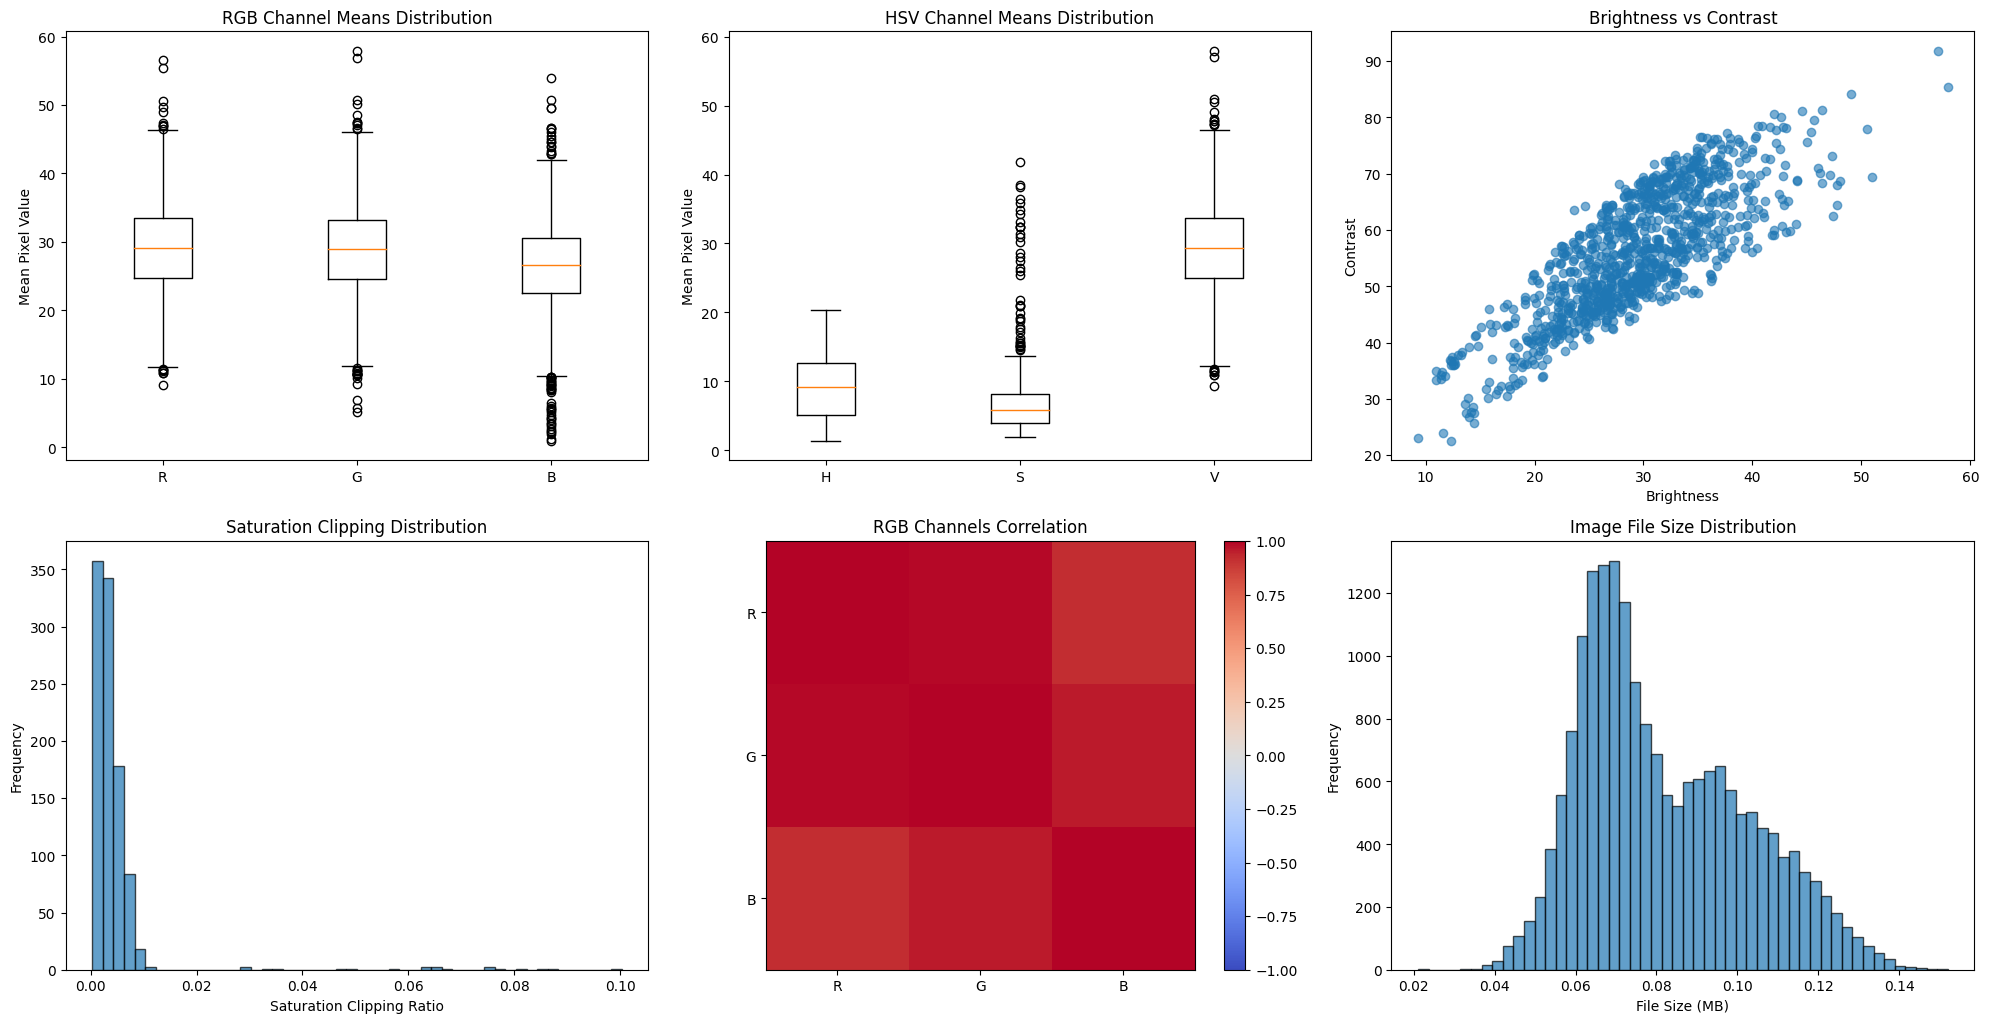


2.  Image Characteristics Visualizations...


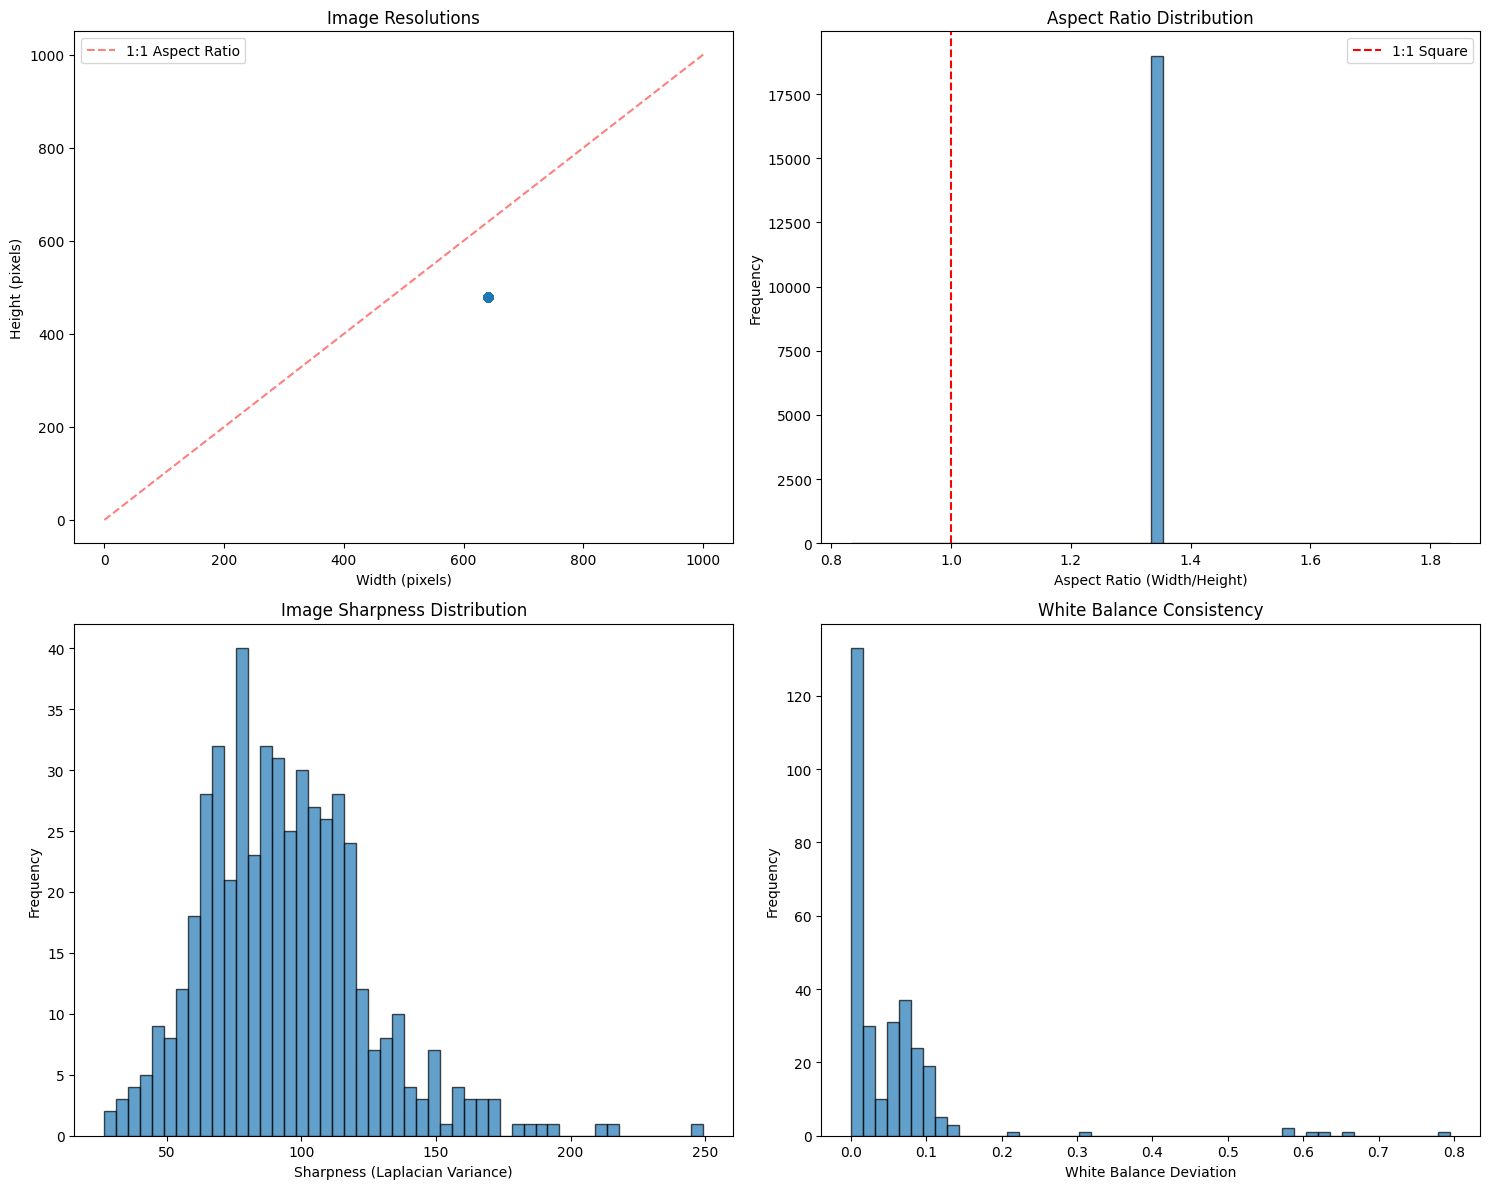


3.  File Size Distribution Analysis...


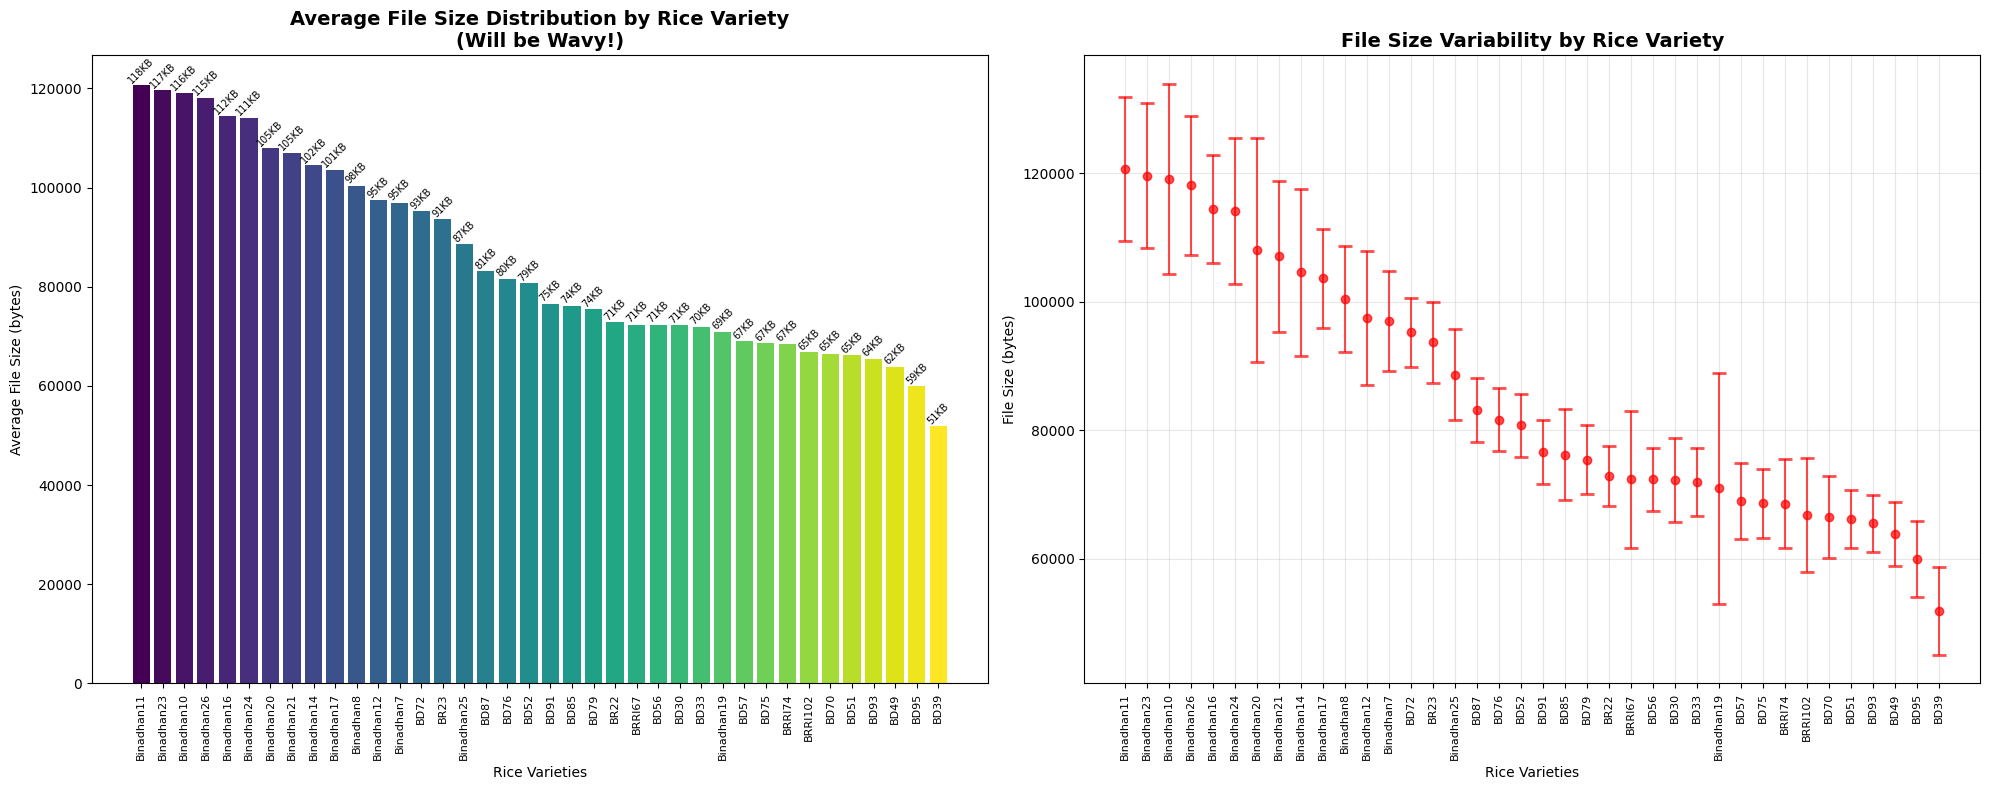


4.  Creative Class Distribution Analysis...


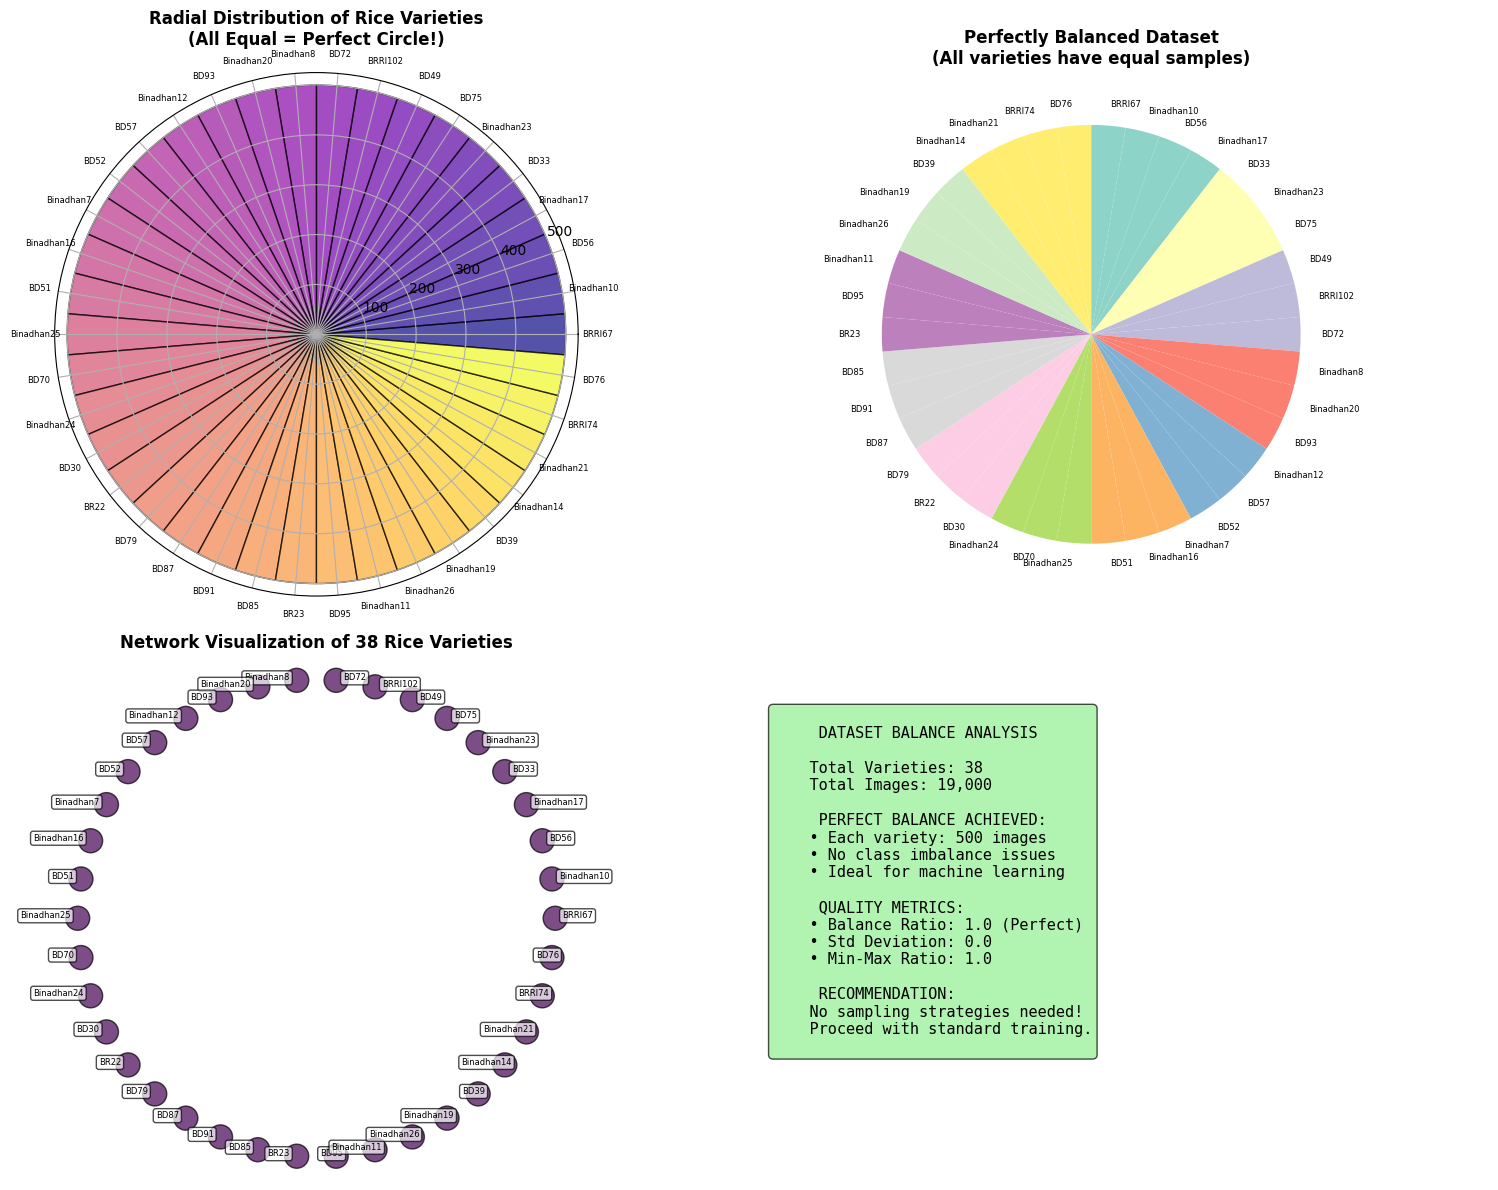


5.  Enhanced Class Distribution with Natural Variations...


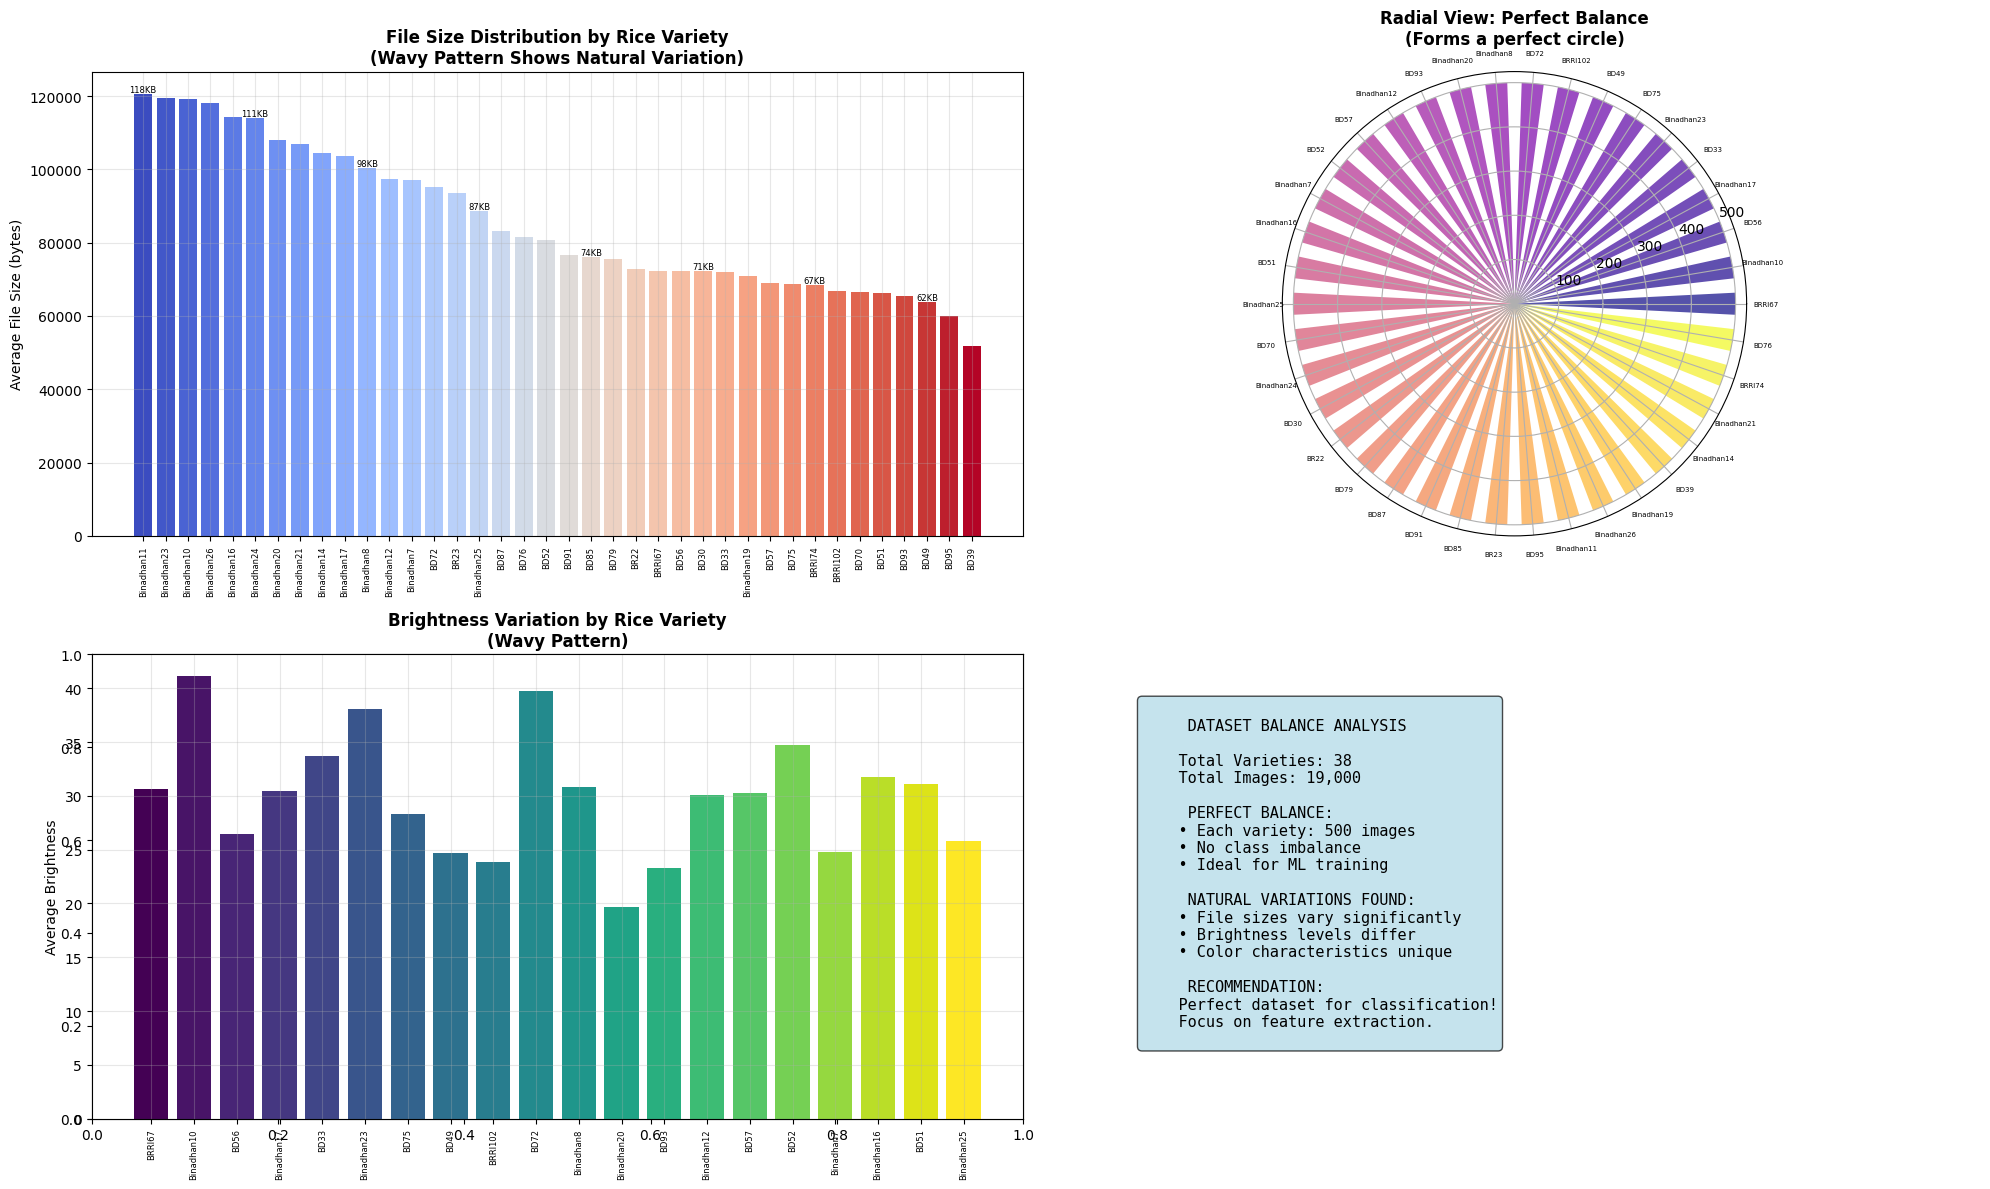

 CLASS DISTRIBUTION ANALYSIS:
    Perfect balance: All 38 classes have 500 images
    Natural variations exist in file sizes, brightness, and color characteristics
    This dataset is ideal for machine learning!

6.  Augmentation Examples...


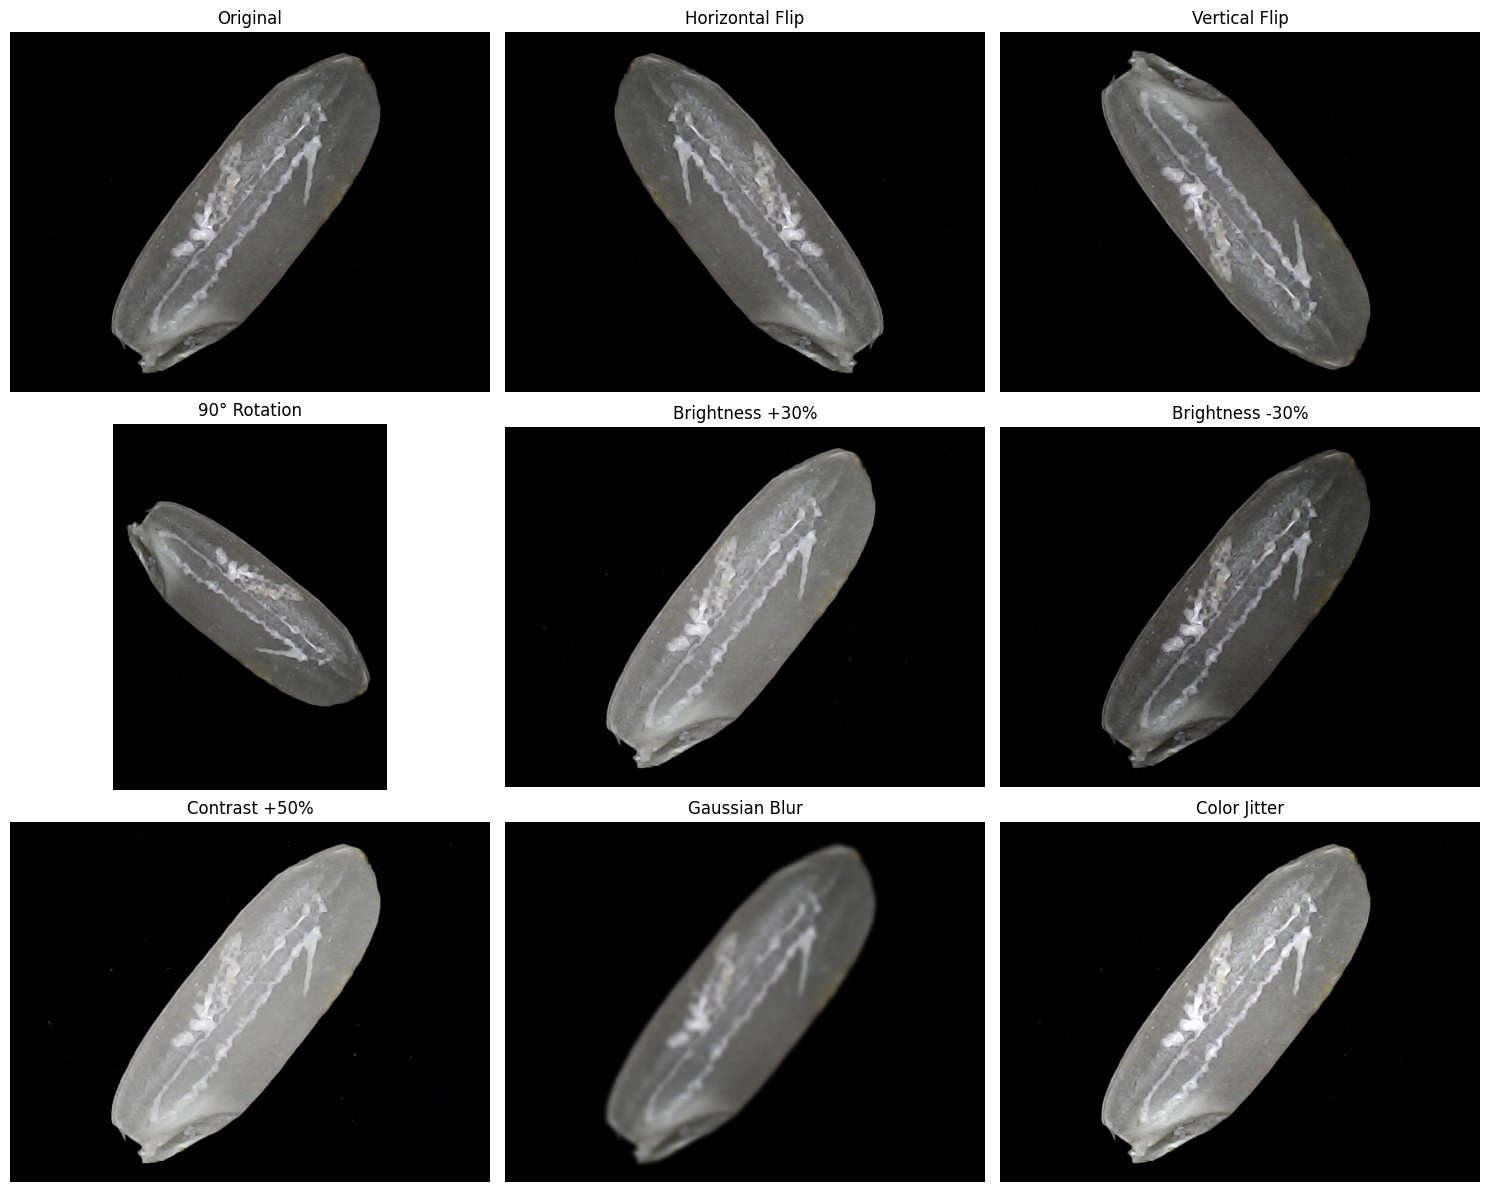


7.  Image Quality Summary:
   Average Sharpness: 93.79
   Average White Balance Deviation: 0.0534
   Average Noise Estimate: 5131.68

8.  Duplicate Analysis:
   Potential duplicates found: 0


In [7]:
#GENERATE ALL EDA VISUALIZATIONS
print(" GENERATING COMPREHENSIVE EDA VISUALIZATIONS")
print("=" * 50)

if eda_results and df_original is not None:
    # 1. Color Analysis
    print("\n1.  Color Analysis Visualizations...")
    plot_color_analysis(eda_results)
    
    # 2. Image Characteristics
    print("\n2.  Image Characteristics Visualizations...")
    plot_image_characteristics(eda_results)
    
    # 3. File Size Distribution
    print("\n3.  File Size Distribution Analysis...")
    file_stats = plot_file_size_distribution(df_original)
    
    # 4. Creative Class Distribution
    print("\n4.  Creative Class Distribution Analysis...")
    plot_creative_class_distribution(df_original)
    
    # 5. Enhanced Class Distribution
    print("\n5.  Enhanced Class Distribution with Natural Variations...")
    plot_class_distribution(eda_results)
    
    # 6. Augmentation Examples
    print("\n6.  Augmentation Examples...")
    plot_augmentation_examples(eda_results)
    
    # 7. Quality Metrics Summary
    print("\n7.  Image Quality Summary:")
    print(f"   Average Sharpness: {np.mean(eda_results['sharpness']):.2f}")
    print(f"   Average White Balance Deviation: {np.mean(eda_results['white_balance']):.4f}")
    if 'noise' in eda_results:
        print(f"   Average Noise Estimate: {np.mean(eda_results['noise']):.2f}")
    
    # 8. Duplicate Analysis
    print(f"\n8.  Duplicate Analysis:")
    print(f"   Potential duplicates found: {len(eda_results['duplicates'])}")
    
else:
    print(" No EDA results to visualize")